In [8]:
**This notebook needs to review again`m**

SyntaxError: invalid syntax (<ipython-input-8-80456a46c0c9>, line 1)



Traditional timeseries forecast alg is aimed as univariate timeseries where onle single feature beside datime index. These includes common statsmodel library with SARIMA model, similar is fb Prophet algorithm.

In general, we need to check stationary condition and do additional steps for make timeseries data become stationary before applying these approaches.

Unlike other machine learning algorithms, convolutional neural networks are capable of automatically learning features from sequence data, support multiple-variate data, and can directly output a vector for multi-step forecasting. As such, one-dimensional CNNs have been demonstrated to perform well and even achieve state-of-the-art results on challenging sequence prediction problems. In this notebook, we will discover how to develop 1D convolutional neural networks for multi-step time series forecasting.   

Here we use data representing a multivariate time series of power-related variables that in turn could be used to model and even forecast future electricity consumptionhow to develop 1D convolutional neural networks for multi-step time series forecasting.   

**Exploring data** refers to **MultivariateTimeSeries_HouseHold_forecast** notebook and **UnivariateTimeseries_HouseHold_Sarimax**   

we will explore how to develop three different types of CNN models for multi-step time series forecasting; they are:      
* A CNN for multi-step time series forecasting with univariate input data.   
􏰀* A CNN for multi-step time series forecasting with multivariate input data via channels.   
􏰀* A CNN for multi-step time series forecasting with multivariate input data via submodels.   


Problem: **Given some number of prior days of total daily power consumption, predict the next standard week of daily power consumption**. The number of prior days used as input defines the one-dimensional (1D) subsequence of data that the CNN will read and learn to extract features. Some ideas on the size and nature of this input include:   
􏰀 All prior days, up to years worth of data.   
􏰀 The prior seven days.   
􏰀 The prior two weeks.   
􏰀 The prior one month.   
􏰀 The prior one year.  
􏰀 The prior week and the week to be predicted from one year ago.  

A good starting point would be to use the prior seven days. A 1D CNN model expects data to have the shape of: [samples, timesteps, features]. One sample will be comprised of seven time steps with one feature for the seven days of total daily power consumed. The training dataset has 159 weeks of data, so the shape of the training dataset would be: [159, 7, 1].   


The data in this format would use the prior standard week to predict the next standard week. A problem is that 159 instances is not a lot for a neural network. A way to create a lot more training data is to change the problem during training to predict the next seven days given the prior seven days, regardless of the standard week.   

This only impacts the training data, the test problem remains the same: predict the daily power consumption for the next standard week given the prior standard week. This will require a little preparation of the training data. The training data is provided in standard weeks with eight variables, specifically in the shape [159, 7, 8]. 

In [1]:
from math import sqrt
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten

Using TensorFlow backend.
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tridoan/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tridoan/opt/anaconda3/lib/pytho

In [2]:
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [3]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks

    train, test = data[1:-328], data[-328:-6]
      # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
    # calculate an RMSE score for each day 
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
   # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1])) 
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

The training data is provided in standard weeks with eight variables, specifically in the shape [159, 7, 8]. The first step is to flatten the data so that we have eight time series sequences.

We then need to iterate over the time steps and divide the data into overlapping windows; each iteration moves along one time step and predicts the subsequent seven days.    

We can do this by keeping track of start and end indexes for the inputs and outputs as we iterate across the length of the flattened data in terms of time steps. We can also do this in a way where the number of inputs and outputs are parameterized (e.g. n input, n out) so that we can experiment with different values or adapt it for other problem.   

The following function **supervised()** takes a list of weeks (history) and the number of time steps to use as inputs and outputs and returns the data in the overlapping moving window format.

In [4]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        # ensure we have enough data for this instance if out_end <= len(data):
        x_input = data[in_start:in_end, 0]
        x_input = x_input.reshape((len(x_input), 1)) 
        X.append(x_input)
        y.append(data[in_end:out_end, 0])

        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)


Running this function on the entire training dataset, we transform 159 samples into 1,100; specifically, the transformed dataset has the shapes X=[1100, 7, 1] and y=[1100, 7].

Next, we can define and fit the CNN model on the training data. This multi-step time series forecasting problem is an autoregression. That means it is likely best modeled where that the next seven days is some function of observations at prior time steps.   

This and the relatively small amount of data means that a small model is required. We will use **a model with one convolution layer with 16 filters and a kernel size of 3**. This means that the input sequence of seven days will be read with a convolutional operation three time steps at a time and this operation will be performed 16 times. A pooling layer will reduce these feature maps by 14 their size before the internal representation is flattened to one long vector. This is then interpreted by a fully connected layer before the output layer predicts the next seven days in the sequence.

In [5]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(16, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

**How the model can be used to make a prediction**   

Generally, the model expects data to have the same three dimensional shape when making a prediction. In this case, the expected shape of an input pattern is one sample, seven days of one feature for the daily power consumed: [1, 7, 1].

Data must have this shape when making predictions for the test set and when a final model is being used to make predictions in the future. Note: **If we change the number of input days to 14, then the shape of the training data and the shape of new samples when making predictions must be changed accordingly to have 14 time steps.** 


We are using walk-forward validation to evaluate the model as described in the previous section. This means that we have the observations available for the prior week in order to predict the coming week. These are collected into an array of standard weeks, called history. In order to predict the next standard week, we need to retrieve the last days of observations. 

As with the training data, we must first flatten the history data to remove the weekly structure so that we end up with eight parallel time series.

we need to retrieve the last seven days of daily total power consumed (feature number 0). We will parameterize as we did for the training data so that the number of prior days used as input by the model can be modified in the future.

Next, we reshape the input into the expected three-dimensional structure.

In [6]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted): 
    scores = list()
    # calculate an RMSE score for each day 
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
  
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1])) 
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))
    
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
    # ensure we have enough data for this instance 
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1)) 
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
    return np.array(X), np.array(y)
          


# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2])) 
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input): # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data 
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
            # store the predictions
        predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
cnn: [796.533] 452.1, 599.5, 1453.5, 695.8, 410.4, 930.8, 495.9


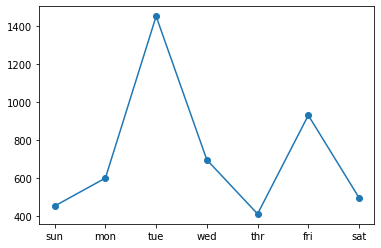

In [7]:
# load the new file
dataset = pd.read_csv('./Downloads/data/household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7

score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
plt.plot(days, scores, marker='o', label='cnn')
plt.show()